# Table of Contents
* [Load Packages and Data](#Load-Packages-and-Data)
* [Topic Modeling](#Topic-Modeling) 
    * [Clean-up Review Text](#Clean-up-Review-Text)
    * [Create the Document-Word Matrix](#Create-the-Document-Word-Matrix)
    * [Build LDA Model with sklearn](#Build-LDA-Model-with-sklearn)
    * [Find the Best LDA Model](#Find-the-Best-LDA-Model)
    * [Dominant Topic in each Document](#Dominant-Topic-in-each-Document)
    * [Visualize the LDA Model with pyLDAvis](#Visualize-the-LDA-Model-with-pyLDAvis)
    * [Try the 2-topic LDA Model](#Try-the-2-topic-LDA-Model)

* [Build Machine Learning Models for Prediction](#Build-Machine-Learning-Models-for-Prediction)
    * [Create a Target Column](#Create-a-Target-Column)
    * [Use LDA Topics for Prediction](#Use-LDA-Topics-for-Prediction)
    * [Use bag-of-word Features for Prediction](#Use-bag-of-word-Features-for-Prediction)
        * [Grid Search Hyperparameter](#Grid-Search-Hyperparameter)
        * [Strongly Predictive Features](#Strongly-Predictive-Features)
    * [Use Tfidf-weighted Features for Prediction](#Use-Tfidf-weighted-Features-for-Prediction)
        * [WordCloud](#WordCloud)
        * [Feed TfidfVectorized Features to Classifier](#Feed-TfidfVectorized-Features-to-Classifier)
        * [Feed Less TfidfVectorized Features to Classifier](#Feed-Less-TfidfVectorized-Features-to-Classifier)
    * [Compare Model Performance](Compare-Model-Performance)

# Load Packages and Data 
This is the second part of the capstone project that investigates reviews dataset of hotels. It focuses on wrangling the text data and uses word features to train a machine learning classifier for hotel classification based on the review texts. 

In [14]:
import warnings
warnings.filterwarnings('ignore')

#manipulate and view data in tabular format
import pandas as pd
import numpy as np

#process text
import re,nltk,spacy,gensim
from collections import Counter
from wordcloud import WordCloud, STOPWORDS


#visualization tools
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

#seaborn
import seaborn as sns
sns.set(context='paper',style='whitegrid',font_scale=2, rc={"lines.linewidth": 2.5})#style=whitegrid,darkgrid,white,dark
pd.set_option('display.max_columns', None)


#LDA visualzation
import pyLDAvis
import pyLDAvis.sklearn



#sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from pprint import pprint #Data pretty printer
from sklearn.feature_selection import SelectKBest,chi2




We've cleaned the raw hotel data as reported in the [milestone report](https://github.com/phyhouhou/SpringboardProjects/blob/master/SecondCapstoneProject/2ndCapstoneProject_MilestoneReport/2ndCapstoneProject_Milestone.ipynb) by handling missing values, drop duplilcates and cleaning and enriching features. Here we load the cleaned hotel data for analysis and focus on the review texts.

In [2]:
data=pd.read_csv('data/htl_clean.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515212 entries, 0 to 515211
Data columns (total 24 columns):
Review_Date                                   515212 non-null object
Review_Month                                  515212 non-null object
Review_Wday                                   515212 non-null object
Hotel_Name                                    515212 non-null object
Hotel_Address                                 515212 non-null object
Hotel_City                                    515212 non-null object
lat                                           511944 non-null float64
lng                                           511944 non-null float64
Average_Score                                 515212 non-null float64
Total_Number_of_Reviews                       515212 non-null int64
Reviewer_Nationality                          515212 non-null object
Total_Number_of_Reviews_Reviewer_Has_Given    515212 non-null int64
Reviewer_Score                                515212 non-nul

,Review_Date,Review_Month,Review_Wday,Hotel_Name,Hotel_Address,Hotel_City,lat,lng,Average_Score,Total_Number_of_Reviews,Reviewer_Nationality,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Negative_Review,Review_Total_Negative_Word_Counts,Neg_Rev_WCRatio,Positive_Review,Review_Total_Positive_Word_Counts,Pos_Rev_WCRatio,Trip_Type,Traveler_Type,Num_Nights,Additional_Number_of_Scoring,days_since_review
0,2017-08-03,Aug,Thu,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,Russia,7,2.9,I am so angry that i made this post available...,397,0.973039,Only the park outside of the hotel was beauti...,11,0.026961,Leisure trip,Couple,6.0,194,0
1,2017-08-03,Aug,Thu,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,Ireland,7,7.5,No Negative,0,0.000000,No real complaints the hotel was great great ...,105,1.000000,Leisure trip,Couple,4.0,194,0
2,2017-07-31,Jul,Mon,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,Australia,9,7.1,Rooms are nice but for elderly a bit difficul...,42,0.666667,Location was good and staff were ok It is cut...,21,0.333333,Leisure trip,Family with young children,3.0,194,3
3,2017-07-31,Jul,Mon,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,United Kingdom,1,3.8,My room was dirty and I was afraid to walk ba...,210,0.889831,Great location in nice surroundings the bar a...,26,0.110169,Leisure trip,Solo traveler,3.0,194,3
4,2017-07-24,Jul,Mon,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,New Zealand,3,6.7,You When I booked with your company on line y...,140,0.945946,Amazing location and building Romantic setting,8,0.054054,Leisure trip,Couple,2.0,194,10


In [3]:
# Reorganize columns
categories=['Review_Month','Hotel_City','Reviewer_Nationality','Trip_Type','Traveler_Type']
numerics=['Total_Number_of_Reviews_Reviewer_Has_Given','Review_Total_Positive_Word_Counts','Review_Total_Negative_Word_Counts','Num_Nights']
text=['Negative_Review','Positive_Review']

cols=categories+text+['Reviewer_Score']
df_txt=data[cols]


# Topic Modeling 
The aim  of topic modeling is to extract hidden topics from a large volume of texts and LDA is a popular algorithm for topic modeling. In this section, we will first clean the texts and then create a word-document matrix, which is a required input for implementing the LDA algorithm. We will then build a LDA model and discuss the model performance to find out what topics reviewers are talking about. 

## Clean-up Review Text 

Review texts will be processed in the following steps:

* Remove all non-letters characters;
* Strip whitespaces;
* Tokenize sentence into a list of words;
* Remove English stopwords;
* Lemmatize words to its roots.


In [4]:
import warnings
warnings.filterwarnings('ignore')


df_txt.Negative_Review.replace('No Negative', ' ',inplace=True)
df_txt.Positive_Review.replace('No Positive', ' ',inplace=True)

# Combine positive and negative reviews
Full_Review=df_txt.Negative_Review+' '+df_txt.Positive_Review
for num,message in enumerate(Full_Review.sample(5, random_state=100)):
    print(num,message)
    print ('\n')


0  It was a bit far from the metro station Sondrio like 15 minutes on foot but you could take the 81 line bus to go to milano centrale which was close enough  Very nice Breakfast Clean and cozy room and great price for it s quality


1    Location for all kind of activities


2  Too much noise from the housekeeping It was like and earthquake moving the beds from the rooms nearby We had to put a complaint in reception  The location


3    Good location not only to tourist attractions but also to supermarket helpful staff delicious breakfast 


4    Excellent view lovely hotel Enjoyed our stay 




In [5]:
#---------Prepare the review text column--------
def prepare_txt(txts): #txts=df[txt_col]
    # Convert reviews to a list
    texts=txts.values.tolist()
    
    # Remove non-letter characters
    texts=[re.sub('[^a-zA-Z]',' ', t) for t in texts]
    
    # Strip whitespaces
    texts=[t.strip() for t in texts]
    
    return texts
   
#----------Remove Stopwords-----------------   
#Prepare NLTK stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['hotel'])

# Tokenize and Remove stopwords
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


#-----------Lemmatization------------------
import warnings
warnings.filterwarnings('ignore')

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation. All pronouns are lemmatized to the special token -PRON-"""
    texts_lemma = []
    for w in texts:
        doc = nlp(' '.join(w)) 
        texts_lemma.append(' '.join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_lemma


In [ ]:
# Caution: very time-consuming. We've saved the lemmatized reviews in a csv file
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
neg_reviews=remove_stopwords(prepare_txt(df_txt['Negative_Review']))
pos_reviews=remove_stopwords(prepare_txt(df_txt['Positive_Review']))


neg_rev_lemmatized = lemmatization(neg_reviews, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
pos_rev_lemmatized = lemmatization(pos_reviews, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



# Save the lemmatized reviews
df_txt['Neg_Rev_Lemmatized']=neg_rev_lemmatized
df_txt['Pos_Rev_Lemmatized']=pos_rev_lemmatized


df_txt.to_csv('data/htl_rev_lem_added.csv',index=False) 


In [6]:
df_txt=pd.read_csv('data/htl_rev_lem_added.csv')

# Join negative and positive reviews
df_txt['Rev_Lemmatized']=df_txt['Neg_Rev_Lemmatized'].fillna('')+' '+df_txt['Pos_Rev_Lemmatized'].fillna('')

df_txt.head()

,Review_Month,Hotel_City,Reviewer_Nationality,Trip_Type,Traveler_Type,Negative_Review,Positive_Review,Reviewer_Score,Neg_Rev_Lemmatized,Pos_Rev_Lemmatized,Rev_Lemmatized
0,Aug,Amsterdam,Russia,Leisure trip,Couple,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,2.9,angry make post available possible site use pl...,park beautiful,angry make post available possible site use pl...
1,Aug,Amsterdam,Ireland,Leisure trip,Couple,,No real complaints the hotel was great great ...,7.5,NaN,real complaint great great location surroundin...,real complaint great great location surroundi...
2,Jul,Amsterdam,Australia,Leisure trip,Family with young children,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,7.1,room nice elderly bit difficult room story nar...,location good staff cute breakfast range nice ...,room nice elderly bit difficult room story nar...
3,Jul,Amsterdam,United Kingdom,Leisure trip,Solo traveler,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,3.8,room dirty afraid walk barefoot floor look cle...,great location nice surrounding bar restaurant...,room dirty afraid walk barefoot floor look cle...
4,Jul,Amsterdam,New Zealand,Leisure trip,Couple,You When I booked with your company on line y...,Amazing location and building Romantic setting,6.7,book company line show picture room think get ...,amazing location build romantic setting,book company line show picture room think get ...


## Create the Document-Word Matrix 
We create the document-word matrix by using CountVectorizer as the main input of the LDA topic model. Since the review data is very large, we only consider words that has occurred at at least 10 times (min_df) and with at least character length 3 , remove built-in english stopwords and convert all words to lowercase.

In [7]:
# Initialise the CountVectorizer with the required configuration
c_vec = CountVectorizer(analyzer='word',       
                             min_df=10,                       
                             stop_words='english',             
                             lowercase=True,                  
                             token_pattern='[a-zA-Z]{3,}',    # num chars > 3 
                             #max_features=10000             # max number of unique words
                            )

# Joined negative and positive reviews
rev_lemmatized=df_txt['Rev_Lemmatized']

# Build the vocabulary by 'fit'
c_vec.fit(rev_lemmatized)

# Convert reviews to a bag of words
rev_vectorized=c_vec.transform(rev_lemmatized) 

In [8]:
# Check the sparscity, i.e., percentage of Non-Zero cells
print ('Shape of Sparse Matrix: ', rev_vectorized.shape)
print ('Amount of Non-Zero occurences: ', rev_vectorized.nnz)
print ('sparsity: %.2f%%' % (100.0 * rev_vectorized.nnz / (rev_vectorized.shape[0] * rev_vectorized.shape[1])))

Shape of Sparse Matrix:  (515212, 10832)
Amount of Non-Zero occurences:  7196408
sparsity: 0.13%


In [ ]:
# min_df=5
# Shape of Sparse Matrix:  (515212, 65464)
# Amount of Non-Zero occurences:  7300472
# sparsity: 0.02%

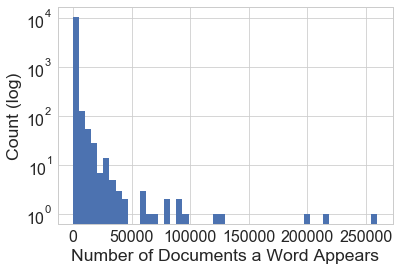

In [9]:
#Calculate 'count' as the number of documents that a word appears 
count=(rev_vectorized>0).sum(axis=0).A.tolist()[0]#count as 1 if the word appear in a document regardless how many times it appear
plt.hist(count,bins=50,log=True)
plt.xlabel('Number of Documents a Word Appears')
plt.ylabel('Count (log)');

Some of the words appear in too many documents.

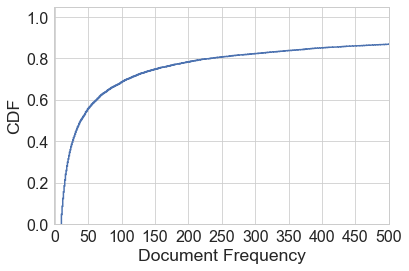

In [10]:
#Construct the cumulative distribution of document frequencies (df)
plt.hist(count,bins=np.unique(count),cumulative=True,density=True,histtype='step',linewidth=1.5);
plt.xlabel('Document Frequency')
plt.ylabel('CDF')
plt.xticks(np.arange(0,501,50))
plt.xlim(-1,500);



This CDF plot justified us in setting 'min_df'=10 around which the curve starts to climb steeply.

In [11]:
# Word feature in each column of the transformed matrix
wfeatures=c_vec.get_feature_names()
print("Lengh of features:",len(wfeatures))

Lengh of features: 10832


In [12]:
# Word and its count
d=dict(zip(wfeatures, np.ravel(rev_vectorized.sum(axis=0))))
print('\n Top 100 Features in the bag-of-word and the counts:\n')
pd.DataFrame(sorted(d.items(),key=lambda x: x[1],reverse=True)[:100],columns=['word','count'])


 Top 100 Features in the bag-of-word and the counts:



,word,count
0,room,391599
1,staff,236504
2,location,204562
3,good,153669
4,breakfast,145485
5,great,115828
6,bed,102823
7,friendly,90236
8,clean,85316
9,helpful,80480


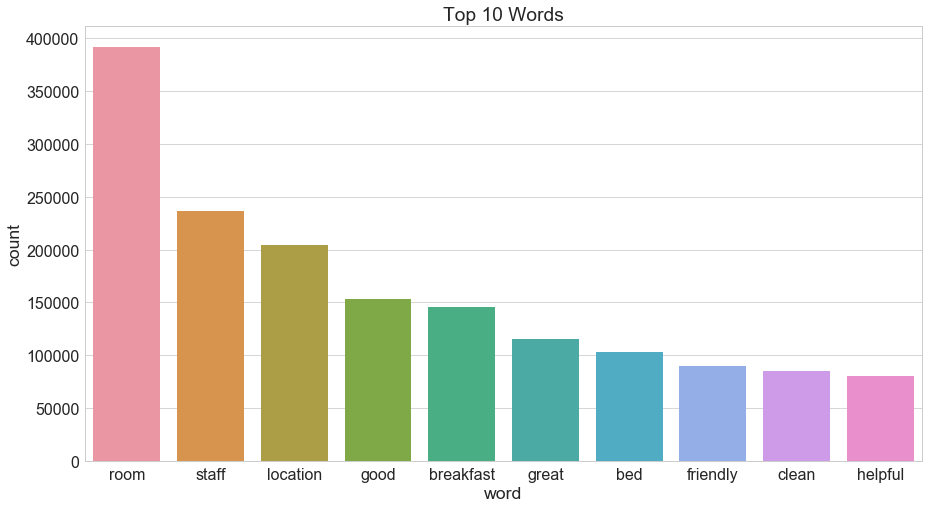

In [13]:
# Visualize counts of words
d=dict(zip(wfeatures, np.ravel(rev_vectorized.sum(axis=0))))
w_c=pd.DataFrame.from_dict((d),orient='index').reset_index()
w_c.columns=('word','count')
w_c=w_c.sort_values(by='count',ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(x='word', y='count', data=w_c.head(10).sort_values('count',ascending=False))            
plt.title("Top 10 Words");

## Build LDA Model with sklearn
We feed the bag of words to LDA model to group words into topics.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Use default parameters. Note it's time-consuming 
lda_model = LDA()                                 
lda_model.fit(rev_vectorized)
lda_output = lda_model.transform(rev_vectorized)


In [90]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 10
feature_names=c_vec.get_feature_names()
display_topics(lda_model, feature_names, num_top_words)

Topic 0:
great location room breakfast view amazing staff beautiful service convenient
Topic 1:
close station walk location good city metro minute easy central
Topic 2:
stay staff bar fantastic restaurant recommend love make excellent definitely
Topic 3:
room check time day book ask staff night reception pay
Topic 4:
room window poor air hot noise night work open noisy
Topic 5:
perfect pool stay enjoy spa really service customer gym bad
Topic 6:
breakfast good price facility food welcome choice expensive include extra
Topic 7:
room good small location breakfast clean nice bed bathroom wifi
Topic 8:
staff friendly helpful location room excellent breakfast good clean comfortable
Topic 9:
room bed shower bathroom comfy coffee comfortable nice tea floor


Topic 0 mentioned 'location', 'room', 'breakfast', 'staff', 'service' and is very general.<br>
Topic 1 focuses on location and transport.<br>
Topic 2 talks about food ('bar', 'restaurant').<br>
Topic 3 talks about reception check-in.<br>
Topic 4 is a negative topic (poor, noisy mentioned).<br>
Topic 5 is about sports entertainment, i.e., pool, spa, gym etc.<br>
Topic 6 seems to focus on price, facility and breakfast.<br>
Topic 7 mentioned room, location, breakfast and wifi.<br>
Topic 8 is again quite general ('staff', 'location', 'room', 'breakfast').<br>
Topic 9 is also on rooms (bed, bathroom, floor) and drinks ('coffee' and 'tea').<br>

In [92]:
# Diagnose model performance with perplexity and log-likelihood

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(rev_vectorized))

# Perplexity: Lower the better
print("Perplexity: ", lda_model.perplexity(rev_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -52724337.00698459
Perplexity:  821.1316849910479
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': 0,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### Find the Best LDA Model 
Since we have limited computing resources, we will focus on tuning the most important parameter for LDA models, i.e., n_components (number of topics).

In [93]:
# Take several hours
# Define Search Param
search_params = {'n_components': [5, 10]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params) 

# Do the Grid Search
model.fit(rev_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [5, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [94]:
# Show the best topic model and its parameters

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(rev_vectorized))


Best Model's Params:  {'n_components': 5}
Best Log Likelihood Score:  -17358897.097666238
Model Perplexity:  721.0095694542667


So n_components=5 outperforms n_components=10. We will set n_components=5 in the following LDA models.

**Save the best_lda_model**

Since it's quite time-consuming to train the LDA model, we save the model in the disk.

In [14]:
# #https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

# from sklearn.externals import joblib
# fn='best_lda.sav'

# # save the model to disk 
# joblib.dump(best_lda_model,fn)

In [15]:
from sklearn.externals import joblib
fn='best_lda.sav'


#load the model from local working directory
best_lda_model=joblib.load(fn)
#loaded_model.get_params
best_lda_model.n_components

5

### Dominant Topic in each Document

What particular topic does a document belong to? A dominant topic in a document is spotted by finding the topic that has the highest contributions (revealed by the document-topic matrix) to that document. We will first display top 20 keywords in all the topics and then make a table to show all major topics in a document and specify the most dominant topic in that document.

#### Display keywords in topics

In [16]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 20
feature_names=c_vec.get_feature_names()
print('Top 20 Words in topics found in the best_lda_model')
display_topics(best_lda_model , feature_names, num_top_words)

Top 20 Words in topics found in the best_lda_model
Topic 0:
room bed bathroom small location good shower clean comfortable nice floor window work size air noise night noisy water door
Topic 1:
room check time stay day night book ask pay staff reception parking make train say charge leave come tell service
Topic 2:
staff location friendly helpful room great excellent breakfast good clean stay comfortable nice bed lovely service perfect really amazing fantastic
Topic 3:
breakfast bar restaurant room coffee food view tea good area service great drink free distance excellent lovely choice facility provide
Topic 4:
good location close room station walk breakfast price nice great city clean metro wifi pool minute easy area restaurant value


Different topics are quite messed up! Topics are of poor quality! Try to reduce the n_components more???

#### Make a  Document - Topic Table 

In [17]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(rev_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df_txt))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topics = df_document_topic.head(10)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.21,0.43,0,0.14,0.22,1
Doc1,0,0.24,0.15,0,0.59,4
Doc2,0.39,0.4,0.01,0.2,0.01,1
Doc3,0.49,0.25,0,0.03,0.22,0
Doc4,0,0.75,0.17,0.03,0.05,1
Doc5,0.06,0.1,0.01,0.47,0.36,3
Doc6,0.62,0.16,0.2,0.01,0.01,0
Doc7,0.14,0.01,0.25,0.35,0.25,3
Doc8,0.36,0.32,0.02,0.18,0.11,0
Doc9,0.52,0.01,0.01,0.25,0.21,0


#### Visualize topics distribution across documents

In [18]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num_Documents")
df_topic_distribution.columns = ['Topic', 'Num_Documents']
df_topic_distribution


,Topic,Num_Documents
0,2,156731
1,0,131552
2,4,101595
3,1,70962
4,3,54372


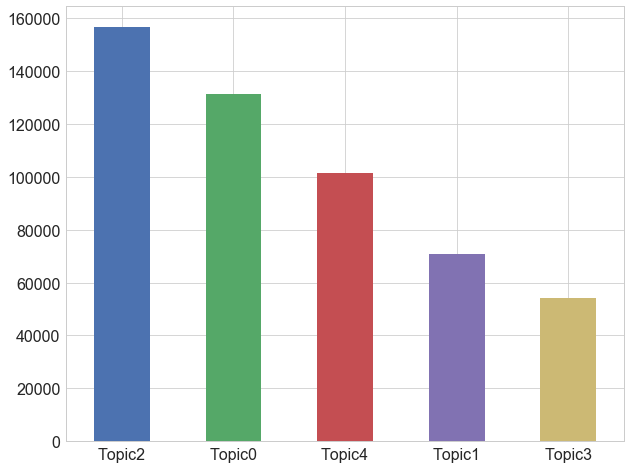

In [19]:
# Visualize the topic distributions across documents
df_topic_distribution['Num_Documents'].plot(kind='bar',rot=0)
plt.xticks(np.arange(0,5),'Topic'+df_topic_distribution['Topic'].astype('str'));

### Visualize the LDA Model with pyLDAvis 

In [23]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, rev_vectorized, c_vec, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
0      21.700312        1       1   -6.750979  -46.153248
4      21.445093        1       2   64.309280 -106.989586
1      20.865534        1       3   64.664154   19.154392
2      20.364604        1       4  151.232605  -15.570311
3      15.624457        1       5  157.712555 -112.127487, topic_info=      Category           Freq        Term          Total  loglift  logprob
term                                                                      
9040   Default  231180.000000       staff  231180.000000  30.0000  30.0000
3941   Default   87917.000000    friendly   87917.000000  29.0000  29.0000
4498   Default   79589.000000     helpful   79589.000000  28.0000  28.0000
5548   Default  200456.000000    location  200456.000000  27.0000  27.0000
853    Default  101399.000000         bed  101399.000000  26.0000  26.0000
747    Default   43617.000000         bar   43617.000000  25.0000  25.0000
1153   Default  154566.000000   breakfast  154566.000000  24.0000  24.0000
804    Default   46887.000000    bathroom   46887.000000  23.0000  23.0000
8136   Default  384604.000000        room  384604.000000  22.0000  22.0000
4260   Default  114738.000000       great  114738.000000  21.0000  21.0000
1794   Default   41269.000000       close   41269.000000  20.0000  20.0000
8752   Default   57184.000000       small   57184.000000  19.0000  19.0000
9096   Default   36916.000000     station   36916.000000  18.0000  18.0000
10503  Default   36328.000000        walk   36328.000000  17.0000  17.0000
8592   Default   35385.000000      shower   35385.000000  16.0000  16.0000
1597   Default   34014.000000       check   34014.000000  15.0000  15.0000
3407   Default   64333.000000   excellent   64333.000000  14.0000  14.0000
9101   Default   67747.000000        stay   67747.000000  13.0000  13.0000
4181   Default  156784.000000        good  156784.000000  12.0000  12.0000
7969   Default   39329.000000  restaurant   39329.000000  11.0000  11.0000
1845   Default   23868.000000      coffee   23868.000000  10.0000  10.0000
7342   Default   28829.000000       price   28829.000000   9.0000   9.0000
1740   Default   87092.000000       clean   87092.000000   8.0000   8.0000
9708   Default   36071.000000        time   36071.000000   7.0000   7.0000
1700   Default   26296.000000        city   26296.000000   6.0000   6.0000
3824   Default   29642.000000        food   29642.000000   5.0000   5.0000
2486   Default   34050.000000         day   34050.000000   4.0000   4.0000
1057   Default   23827.000000        book   23827.000000   3.0000   3.0000
6381   Default   40295.000000       night   40295.000000   2.0000   2.0000
5618   Default   34252.000000      lovely   34252.000000   1.0000   1.0000
...        ...            ...         ...            ...      ...      ...
3133    Topic5    5072.778084         egg    5073.579059   1.8562  -5.4889
8132    Topic5    4918.740507     rooftop    4919.547200   1.8562  -5.5197
3534    Topic5    4875.145469    fabulous    4875.954074   1.8562  -5.5286
5928    Topic5    4537.109295        menu    4537.912197   1.8562  -5.6005
5885    Topic5    3997.210544        meal    3998.014139   1.8561  -5.7272
3968    Topic5    3886.373876       fruit    3887.176339   1.8561  -5.7553
4039    Topic5    3474.794944      garden    3475.601136   1.8561  -5.8673
9815    Topic5    3263.257010       tower    3264.057711   1.8561  -5.9301
5468    Topic5    3134.105335     limited    3134.913523   1.8561  -5.9705
8468    Topic5    5916.097145       serve    5918.633153   1.8559  -5.3351
2747    Topic5    6040.138866      dinner    6058.141129   1.8534  -5.3144
3824    Topic5   23211.697359        food   29642.434624   1.6118  -3.9681
1655    Topic5   11089.911646      choice   13644.883805   1.6490  -4.7068
7969    Topic5   24881.096502  restaurant   39329.152527   1.3985  -3.8987
1153    Topic5   64775.131

### Try the 2-topic LDA Model 

Since some topics have quite common words and are overlapped in then 5-topic LDA model, we need to figure out a way to enhance the clarity of topics. It's very slow to try larger number of topics. We try to set the number of topics to be 2 and we want to know if the LDA model can separate reviews into positive and negative reviews.

In [ ]:
lda_modeln2 = LatentDirichletAllocation(n_components=2,           # default number of topics
                                      max_iter=10,               # default max learning iterations: 10 too slow
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # default num docs in each learning iter
                                      evaluate_every = 0,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_modeln2.fit(rev_vectorized)
lda_output = lda_modeln2.transform(rev_vectorized)


In [104]:
print("Log Likelihood: ", lda_modeln2.score(rev_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_modeln2.perplexity(rev_vectorized))

# See model parameters
pprint(lda_modeln2.get_params())

Log Likelihood:  -51384290.031186365
Perplexity:  692.3724930726793
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': 0,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 2,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [103]:
display_topics(lda_modeln2, feature_names, 30)


Topic 0:
room location staff good great breakfast bed friendly clean nice helpful comfortable excellent small bathroom close station walk shower bit really restaurant perfect view city area little lovely metro quiet
Topic 1:
room stay staff breakfast service time check day make night reception bar free book coffee good ask pay pool price come use food really money work tea feel extra say


The 2-topic model has a higher score (higher Log Likelihood and lower Perplexity score) compared to that of 5-topic model but topics are still overlapped for n_component=2 and the model doesn't seem to classify reviews as negative and positive topics. 

# Build Machine Learning Models for Prediction 
Since we focus on the review texts in this part, we build machine learning models using features generated from texts. Before that we need to create our target variable 'label'. Since a reviewer's score ranges from 0 to 10, for simplicity, we classify a hotel as 'poor' if the score is below 7.1 and 'good' if it's between 7.1 and 9.5 otherwise 'excellent'.

## Create a Target Column

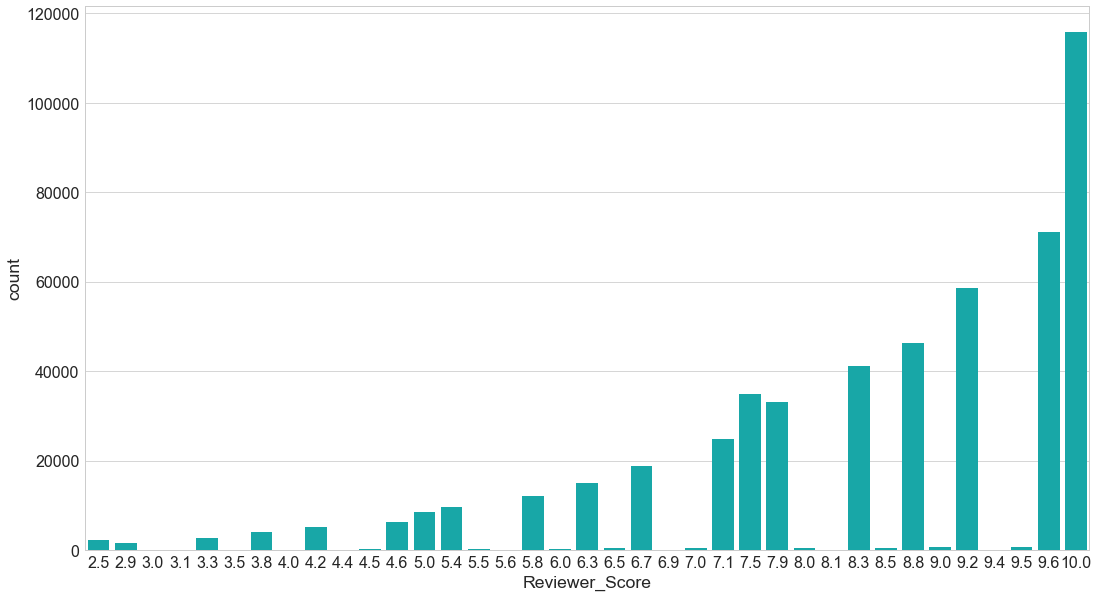

In [24]:
# Visualize the reviewer score
plt.figure(figsize=(18,10))
sns.countplot(df_txt.Reviewer_Score,color='c');

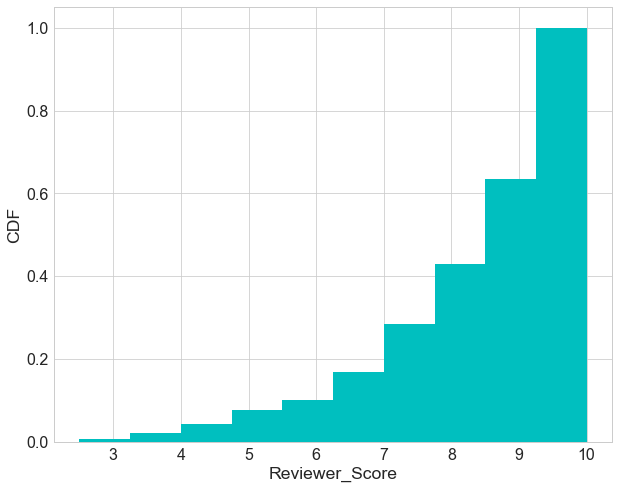

In [25]:
# CDF of the reviewer score
df_txt.Reviewer_Score.plot(kind='hist', cumulative=True,histtype='bar',normed=True,bins=10,color='c')
plt.xlabel('Reviewer_Score')
plt.ylabel('CDF');

In [26]:
#Add 'label' by converting 'continuous' Reviewer_Score into 3 categories
custom_bucket_array=[0.0,7.1,9.5,10.0]
df_txt['label']=pd.cut(df_txt.Reviewer_Score,custom_bucket_array,labels=['Poor','Good','Excellent'])


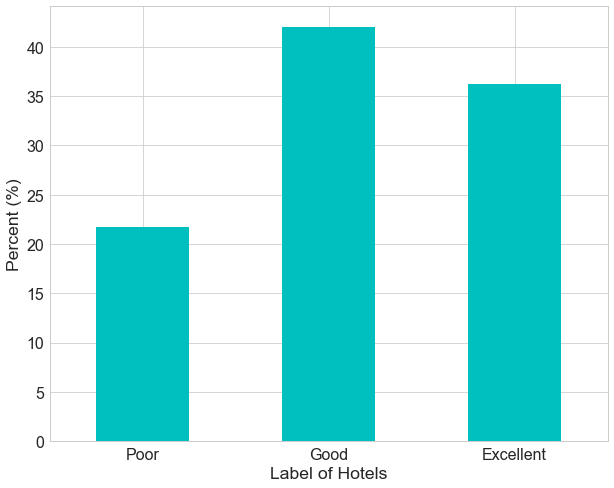

In [27]:
(df_txt.label.value_counts(normalize=True).sort_index()*100).plot(kind='bar',color='c',rot=0,figsize=(10,8));
plt.ylabel('Percent (%)')
plt.xlabel('Label of Hotels');

In [28]:
df_txt.drop('Reviewer_Score',axis=1).groupby('label').describe()

Hotel_City                        Neg_Rev_Lemmatized          \
               count unique     top    freq              count  unique   
label                                                                    
Poor          111964      6  London   61879             107857  100277   
Good          216380      6  London  107599             171356  144168   
Excellent     186868      6  London   92820             103796   65840   

                             Negative_Review                     \
                  top   freq           count  unique top   freq   
label                                                             
Poor       room small    545          111964  104305       3787   
Good          nothing   4761          216380  155650      44016   
Excellent     nothing  17858          186868   74601      80803   

          Pos_Rev_Lemmatized                           Positive_Review  \
                       count  unique         top  freq           count   
label                                                                    
Poor                   92005   59598    location  8800          111964   
Good                  203652  167240    location  4725          216380   
Excellent             182425  159348  everything  2933          186868   

                             Rev_Lemmatized                                    \
           unique top   freq          count  unique                 top  freq   
label                                                                           
Poor        69066      19710         111964  108573            location   271   
Good       182029      12429         216380  206299            location   920   
Excellent  169377       3947         186868  173482  nothing everything  1249   

          Review_Month                    Reviewer_Nationality         \
                 count unique  top   freq                count unique   
label                                                                   
Poor            111964     12  Jul  11323               111964    197   
Good            216380     12  Aug  21239               216380    212   
Excellent       186868     12  Aug  18631               186868    210   

                                   Traveler_Type                         \
                        top   freq         count unique     top    freq   
label                                                                     
Poor        United Kingdom   49966        111964      6  Couple   49133   
Good        United Kingdom   98266        216380      6  Couple  104370   
Excellent   United Kingdom   96878        186868      6  Couple   98502   

          Trip_Type                               
              count unique           top    freq  
label                                             
Poor         107940      2  Leisure trip   82793  
Good         210232      2  Leisure trip  174625  
Excellent    182036      2  Leisure trip  159937

In [29]:
# Lenghth of characters in a full-review
df_txt['Len_LemRev_char']=df_txt['Rev_Lemmatized'].apply(len)


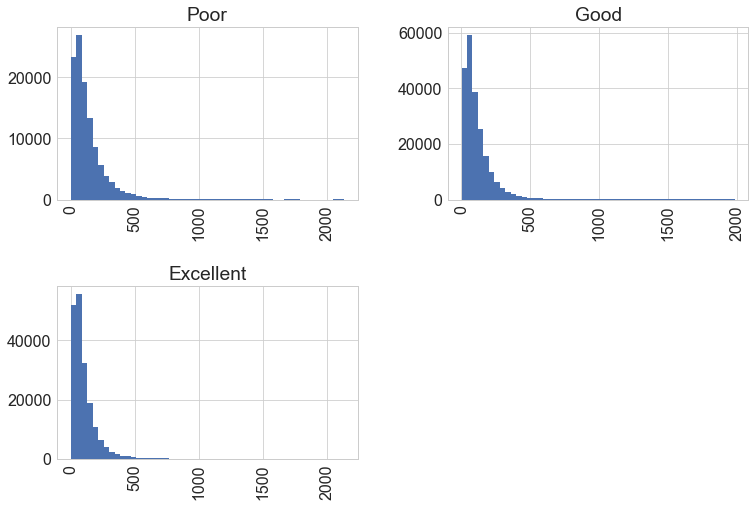

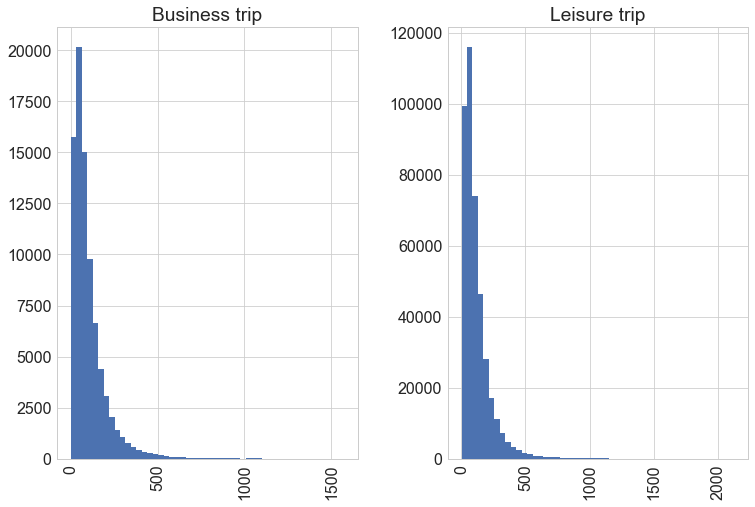

In [30]:
# Visualize the distribution of length of review strings by hotel label
df_txt.hist(column='Len_LemRev_char',by='label',bins=50,figsize=(12,8))
plt.xlabel('length of Characters in a Review');


# Visualize the distribution of length of review strings by traveler type
df_txt.hist(column='Len_LemRev_char',by='Trip_Type',bins=50,figsize=(12,8));



## Use LDA Topics for Prediction 

In [31]:
# Cleaned lemmatized reviews
df_txt_label=df_txt[['Rev_Lemmatized','label']]
df_txt_label['label_cat']=df_txt_label.label.astype('category').cat.codes
df_txt_label.isnull().sum()

Rev_Lemmatized    0
label             0
label_cat         0
dtype: int64

In [32]:
dict(zip(df_txt_label['label'],df_txt_label['label_cat']))

{'Poor': 0, 'Good': 1, 'Excellent': 2}

In [33]:
def make_xy(df_txt_label, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df_txt_label.Rev_Lemmatized)
    X = X.tocsc()  
    y = df_txt_label.label_cat.values
    return X, y


X, y = make_xy(df_txt_label,c_vec)

In [34]:
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.naive_bayes import MultinomialNB


#Split the data into training and test data set
X_train, X_test,y_train,y_test=train_test_split(X,y,random_state=100,test_size=0.3)  
X_train.shape, X_test.shape

((360648, 10832), (154564, 10832))

In [ ]:
# Run LDA
lda = LDA(n_topics=5, random_state=100)
X_train=lda.fit_transform(X_train)
X_test=lda.transform(X_test)

# Train the NB classifier
clf = MultinomialNB().fit(X_train, y_train)
lda_training_accuracy = clf.score(X_train, y_train)
lda_test_accuracy = clf.score(X_test, y_test)

In [36]:
print("Accuracy on training data: {:2f}".format(lda_training_accuracy))
print("Accuracy on test data:     {:2f}".format(lda_test_accuracy))

Accuracy on training data: 0.455563
Accuracy on test data:     0.455766


In [37]:
y_pred=clf.predict(X_test)
lda_class_report=classification_report(y_test,y_pred)
print(lda_class_report)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     33545
          1       0.43      0.87      0.58     64946
          2       0.59      0.25      0.35     56073

avg / total       0.39      0.46      0.37    154564



The accuracy is very low!???

## Use bag-of-word Features for Prediction 

In [38]:
X, y = make_xy(df_txt_label,c_vec)
#Split the data into training and test data set
X_train, X_test,y_train,y_test=train_test_split(X,y,random_state=100,test_size=0.3)  

clf=MultinomialNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

bow_training_accuracy = clf.score(X_train, y_train)
bow_test_accuracy = clf.score(X_test, y_test)
bow_class_report=classification_report(y_test,y_pred)

print("Accuracy on training data: {:2f}".format(bow_training_accuracy))
print("Accuracy on test data:     {:2f}".format(bow_test_accuracy))
print(bow_class_report)

Accuracy on training data: 0.612068
Accuracy on test data:     0.604449
             precision    recall  f1-score   support

          0       0.62      0.58      0.60     33545
          1       0.56      0.57      0.57     64946
          2       0.65      0.65      0.65     56073

avg / total       0.61      0.60      0.60    154564



### Grid Search Hyperparameter 

In [39]:
search_params = {'alpha': [0.01, 0.1, 1,5,10]}
nfolds=5

clf=MultinomialNB()
model=GridSearchCV(estimator = clf, param_grid = search_params,cv=nfolds)
model.fit(X_train,y_train)

# Best Model 
best_model = model.best_estimator_
best_alpha = model.best_params_['alpha']
# Model Parameters
print("Best Model's Params: ", model.best_params_)

Best Model's Params:  {'alpha': 10}


In [41]:
y_pred =model.predict(X_test)

bow_gs_training_accuracy = model.score(X_train, y_train)
bow_gs_test_accuracy = model.score(X_test, y_test)
bow_gs_class_report=classification_report(y_test,y_pred)

print("Accuracy on training data: {:2f}".format(bow_gs_training_accuracy))
print("Accuracy on test data:     {:2f}".format(bow_gs_test_accuracy))
print (bow_gs_class_report)

Accuracy on training data: 0.609777
Accuracy on test data:     0.605516
             precision    recall  f1-score   support

          0       0.63      0.56      0.59     33545
          1       0.56      0.60      0.58     64946
          2       0.65      0.64      0.65     56073

avg / total       0.61      0.61      0.61    154564



Accuray is rarely improved!!!

### Strongly Predictive Features 
We builds a dataset where each row contains just one word (identity matrix) and then uses the trained classifier to classify the one-word review. The probability for each row represents the probability that the review will be classified as 'poor'. We can see which words have the highest probability in ('poor')and which words have the lowest probability (low probability in being 'poor', hence high probability in being 'good' or 'excellent).

In [43]:
# Set the train and test masks
itrain, _ = train_test_split(range(df_txt_label.shape[0]), test_size=0.3,random_state=100)
mask = np.zeros(df_txt_label.shape[0], dtype=np.bool)
mask[itrain] = True

xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]


clf = MultinomialNB(alpha=20).fit(xtrain, ytrain)
words = np.array(c_vec.get_feature_names())

x = np.eye(xtest.shape[1])
# 'poor'
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)[::-1]#reverse the order such that decending order

good_words =words[ind[:10]]   
bad_words =words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(Poor | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(np.exp(p)))
    
print("Bad words\t     P(Poor | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(np.exp(p)))


Good words	     P(Poor | word)
              filthy 0.77
           unhelpful 0.73
               dirty 0.73
          disgusting 0.70
          unfriendly 0.69
                rude 0.69
      unprofessional 0.66
             unclean 0.66
            horrible 0.64
             disgust 0.64
Bad words	     P(Poor | word)
           fantastic 0.04
         exceptional 0.04
           amazingly 0.04
         beautifully 0.04
          spotlessly 0.04
             amazing 0.04
              superb 0.03
            fabulous 0.03
                love 0.03
           wonderful 0.03


## Use Tfidf-weighted Features for Prediction 
If you already have a learned CountVectorizer, you can use it with a TfidfTransformer to just calculate the inverse document frequencies and start encoding documents.

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Initialize the vectorizer
tfidf_vec = TfidfVectorizer(min_df=10,
                            ngram_range=(1, 1),
                            stop_words='english',
                            lowercase=True,
                            token_pattern='[a-zA-Z]{3,}',
                           )

#tokenize and build voc
tfidf_vec.fit(rev_lemmatized);

# encode document as a sparse array
rev_vectorized_tfidf=tfidf_vec.transform(rev_lemmatized)

In [45]:
# summarize encoded vector
print(rev_vectorized_tfidf.shape)
print ('number of non-zeros:', rev_vectorized_tfidf.nnz)
print ('sparsity: %.2f%%' % (100.0 * rev_vectorized_tfidf.nnz / (rev_vectorized_tfidf.shape[0] * rev_vectorized_tfidf.shape[1])))

(515212, 10832)
number of non-zeros: 7196408
sparsity: 0.13%


In [46]:
# get the features
features = np.array(tfidf_vec.get_feature_names())


# find tfidf-maximum value for each of the features over all of datsset
max_tfidf=rev_vectorized_tfidf.max(axis=0).toarray().ravel()

#sort weights and extract their indices
idx=max_tfidf.argsort()

print("Features with lowest tfidf:\n{}".format(
      features[idx[:10]]))

print("\nFeatures with highest tfidf: \n{}".format(
      features[idx[-10:]]))


# get feature names
features = np.array(tfidf_vec.get_feature_names())
sorted_by_idf = np.argsort(tfidf_vec.idf_)
print("Features with lowest idf:\n{}".format(
       features[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       features[sorted_by_idf[-10:]]))

Features with lowest tfidf:
['magically' 'grocer' 'forced' 'iamsterdam' 'humiliate' 'disgruntle'
 'thirdly' 'dismay' 'deprive' 'entirety']

Features with highest tfidf: 
['environment' 'require' 'nearby' 'near' 'connection' 'connected' 'nature'
 'connect' 'report' 'paris']
Features with lowest idf:
['room' 'staff' 'location' 'breakfast' 'good' 'great' 'bed' 'friendly'
 'clean' 'helpful']

Features with highest idf:
['vienne' 'vibrated' 'lighted' 'lifting' 'lifesaver' 'bussy'
 'respectfully' 'bury' 'alain' 'cleand']


### WordCloud 

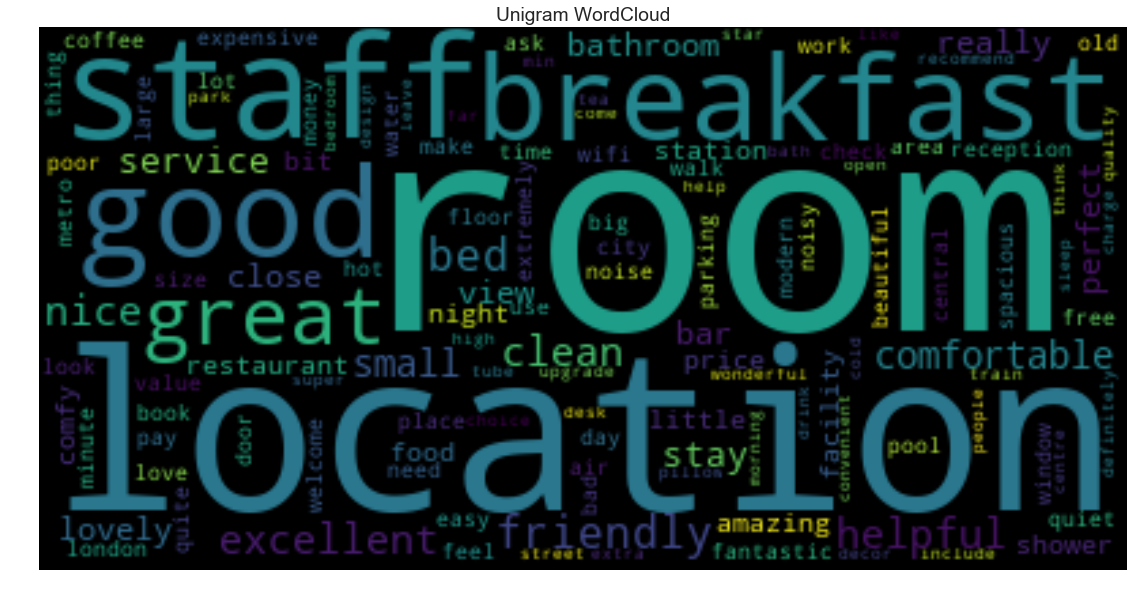

In [48]:
# Ngram
def ngram(n,txt):
    tfidf_vec = TfidfVectorizer(min_df=10, ngram_range=(1, n),stop_words='english',lowercase=True,token_pattern='[a-zA-Z]{3,}',max_features = 5000)
    tfidf_vec.fit(txt)
    tfidf_m=tfidf_vec.transform(txt)
    words_ngram=[w for w in tfidf_vec.get_feature_names() if len(w.split(' '))>n-1]
    idx_ngram=[tfidf_vec.vocabulary_[w] for w in words_ngram]
    dn=dict(zip(words_ngram, np.ravel(tfidf_m.sum(axis=0))[idx_ngram]))
    
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=dn)
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off");
# Unigram wordcloud
ngram(1,rev_lemmatized)
plt.title('Unigram WordCloud');

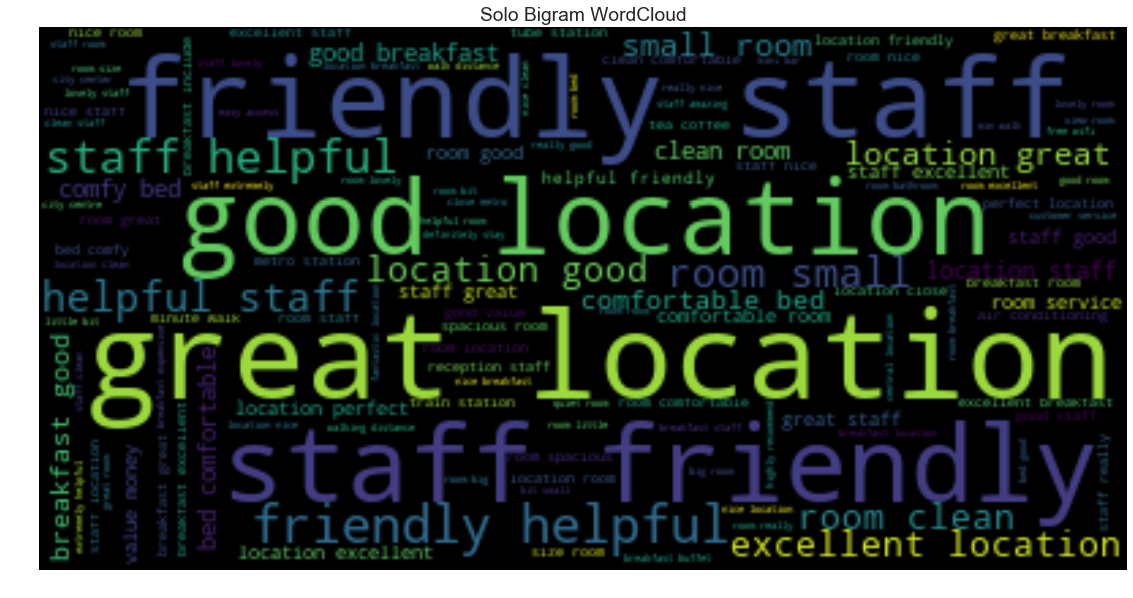

In [49]:
ngram(2,rev_lemmatized)
plt.title('Solo Bigram WordCloud');

### Feed TfidfVectorized Features to Classifier

In [50]:
tfidf_vec = TfidfVectorizer(min_df=10,
                            ngram_range=(1,1),
                            stop_words='english',
                            lowercase=True,
                            token_pattern='[a-zA-Z]{3,}',
                           )
X, y = make_xy(df_txt_label,tfidf_vec)
#Split the data into training and test data set
X_train, X_test,y_train,y_test=train_test_split(X,y,random_state=100,test_size=0.3)  

clf=MultinomialNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

tfidf_training_accuracy = clf.score(X_train, y_train)
tfidf_test_accuracy = clf.score(X_test, y_test)
tfidf_class_report=classification_report(y_test,y_pred)

print("Accuracy on training data: {:.2f}".format(tfidf_training_accuracy))
print("Accuracy on test data:     {:.2f}".format(tfidf_test_accuracy))
print (tfidf_class_report)


Accuracy on training data: 0.61
Accuracy on test data:     0.60
             precision    recall  f1-score   support

          0       0.70      0.44      0.54     33545
          1       0.53      0.70      0.60     64946
          2       0.67      0.58      0.63     56073

avg / total       0.62      0.60      0.60    154564



In [51]:
tfidf_vec = TfidfVectorizer(min_df=10,
                            ngram_range=(1,2),
                            stop_words='english',
                            lowercase=True,
                            token_pattern='[a-zA-Z]{3,}',
                            #max_features = 5000
                           )
X, y = make_xy(df_txt_label,tfidf_vec)
#Split the data into training and test data set
X_train, X_test,y_train,y_test=train_test_split(X,y,random_state=100,test_size=0.3)  

clf=MultinomialNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)


tfidf_2gram_training_accuracy = clf.score(X_train, y_train)
tfidf_2gram_test_accuracy = clf.score(X_test, y_test)
tfidf_2gram_class_report=classification_report(y_test,y_pred)

print("Accuracy on training data: {:.2f}".format(tfidf_2gram_training_accuracy))
print("Accuracy on test data:     {:.2f}".format(tfidf_2gram_test_accuracy))
print (tfidf_2gram_class_report)

Accuracy on training data: 0.66
Accuracy on test data:     0.62
             precision    recall  f1-score   support

          0       0.70      0.52      0.60     33545
          1       0.55      0.67      0.60     64946
          2       0.68      0.61      0.64     56073

avg / total       0.63      0.62      0.62    154564



Accuracy is still so low!

###    Feed Less TfidfVectorized Features to Classifier 

We implement the most common feature selection technique for text mining, i.e., the chi-squared $\left( \chi^2 \right)$ method.

In [53]:
from sklearn.feature_selection import SelectKBest,chi2

X, y = make_xy(df_txt_label,tfidf_vec)
X_new = SelectKBest(chi2, k=5000).fit_transform(X, y)
    
x_train=X_new[mask]
y_train=y[mask]
x_test=X_new[~mask]
y_test=y[~mask]

In [55]:
clf=MultinomialNB()
search_params = {'alpha':[0.001, 0.01, 0.05, 0.1, 1]}
nfolds=5

clf_best = GridSearchCV(estimator = clf, param_grid = search_params, scoring = 'accuracy', cv=nfolds)
clf_best.fit(x_train, y_train)
print("best parameters: ", clf_best.best_params_)
print("\t")

y_predict=clf_best.predict(x_test)

tfidf_chi_training_accuracy=clf_best.score(x_train,y_train)
tfidf_chi_test_accuracy=clf_best.score(x_test,y_test)
tfidf_chi_class_report=classification_report(y_test,y_predict)

best parameters:  {'alpha': 0.01}
	


In [56]:
print("Accuracy on training data: {:.2f}".format(tfidf_chi_training_accuracy))
print("Accuracy on test data:     {:.2f}".format(tfidf_chi_test_accuracy))
print (tfidf_chi_class_report)

Accuracy on training data: 0.62
Accuracy on test data:     0.61
             precision    recall  f1-score   support

          0       0.75      0.47      0.58     33908
          1       0.54      0.73      0.62     64773
          2       0.70      0.56      0.62     55883

avg / total       0.64      0.61      0.61    154564



##  Compare Model Performance

In [65]:
# Accuracy score of the training and test set for each model
d_model_accuracy={'lda':[lda_training_accuracy,lda_test_accuracy],
'bow':[bow_training_accuracy,bow_test_accuracy],
'bow_gs': [bow_gs_training_accuracy,bow_gs_test_accuracy],
 'tfidf':[tfidf_training_accuracy,tfidf_test_accuracy],
 'tfidf_2gram':[tfidf_2gram_training_accuracy,tfidf_2gram_test_accuracy],
 'tfidf_2gram_chi':[tfidf_chi_training_accuracy,tfidf_chi_test_accuracy]}
model_performance=pd.DataFrame.from_dict(d_model_accuracy,orient='index')
model_performance.columns=['training_accuracy','test_accuracy']
np.round(model_performance,2).T

,lda,bow,bow_gs,tfidf,tfidf_2gram,tfidf_2gram_chi
training_accuracy,0.46,0.61,0.61,0.61,0.66,0.62
test_accuracy,0.46,0.60,0.61,0.60,0.62,0.61


In [66]:
# Print classification report
print('lda: \n')
print(lda_class_report)

print('bow: \n')
print(bow_class_report)

print('bow_gs: \n')
print(bow_gs_class_report)

print('tfidf: \n')
print(tfidf_class_report)

print('tfidf_2gram: \n')
print(tfidf_2gram_class_report)

print('tfidf_chi: \n')
print(tfidf_chi_class_report)

lda: 

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     33545
          1       0.43      0.87      0.58     64946
          2       0.59      0.25      0.35     56073

avg / total       0.39      0.46      0.37    154564

bow: 

             precision    recall  f1-score   support

          0       0.62      0.58      0.60     33545
          1       0.56      0.57      0.57     64946
          2       0.65      0.65      0.65     56073

avg / total       0.61      0.60      0.60    154564

bow_gs: 

             precision    recall  f1-score   support

          0       0.63      0.56      0.59     33545
          1       0.56      0.60      0.58     64946
          2       0.65      0.64      0.65     56073

avg / total       0.61      0.61      0.61    154564

tfidf: 

             precision    recall  f1-score   support

          0       0.70      0.44      0.54     33545
          1       0.53      0.70      0.60     64946
   